## Building GP Models from Scratch
Sometimes it is useful to build GP models outside the context of BO for data
visualization and senativity measurements, ie. learned hyperparameters. Here we
demonstrate how to build models from data outside of generators.

For this we use the 3D rosenbrock function test function.

In [1]:
# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")
NUM_MC_SAMPLES = 1 if SMOKE_TEST else 128
NUM_RESTARTS = 1 if SMOKE_TEST else 20

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

from xopt import Xopt, Evaluator
from xopt.generators import RandomGenerator
from xopt.resources.test_functions.rosenbrock import evaluate_rosenbrock,make_rosenbrock_vocs

# make rosenbrock function vocs in 3D
vocs = make_rosenbrock_vocs(3)

# collect some data using random sampling
evaluator = Evaluator(function=evaluate_rosenbrock)
generator = RandomGenerator(vocs=vocs)
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X.random_evaluate(15)

,x0,x1,x2,y,xopt_runtime,xopt_error
0,-1.494186,-0.270845,-0.716194,696.895140,0.000010,False
1,0.895297,0.611722,-1.285482,279.221353,0.000008,False
2,0.096775,-1.414032,-0.619599,895.211104,0.000003,False
3,-0.122976,0.546083,1.795676,253.900307,0.000004,False
4,1.958951,0.350788,-1.974084,1656.846548,0.000003,False
5,1.880075,-1.846074,-1.550278,5362.567643,0.000003,False
6,-1.927964,1.967028,0.092676,1741.977213,0.000003,False
7,0.897436,-1.691367,-1.016928,2134.250111,0.000003,False
8,0.986957,-0.783326,-1.985232,987.421995,0.000002,False
9,0.594882,-0.286495,-1.875982,426.228292,0.000002,False


## Create GP model based on the data

In [2]:
data = X.data

In [3]:
from xopt.generators.bayesian.models.standard import StandardModelConstructor
model_constructor = StandardModelConstructor()

# here we build a model from vocs
model = model_constructor.build_model_from_vocs(
    vocs=vocs, data=data
)

# here we build a model from info (more flexible)
model = model_constructor.build_model(
    input_names=["x0","x1","x2"],
    outcome_names=["y"],
    data=data
)
help(model_constructor.build_model)


Help on method build_model in module xopt.generators.bayesian.models.standard:

build_model(input_names: List[str], outcome_names: List[str], data: pandas.core.frame.DataFrame, input_bounds: Dict[str, List] = None, dtype: torch.dtype = torch.float64, device: Union[torch.device, str] = 'cpu') -> botorch.models.model_list_gp_regression.ModelListGP method of xopt.generators.bayesian.models.standard.StandardModelConstructor instance
    Construct independent models for each objective and constraint.
    
    Parameters
    ----------
    input_names : List[str]
        Names of input variables.
    outcome_names : List[str]
        Names of outcome variables.
    data : pd.DataFrame
        Data used for training the model.
    input_bounds : Dict[str, List], optional
        Bounds for input variables.
    dtype : torch.dtype, optional
        Data type for the model (default is torch.double).
    device : Union[torch.device, str], optional
        Device on which to perform computations 

## Examine GP model hyperparameters
Here we look at the GP hyperparameters for the objective function (the first model).
Note: the hyperparameters here are in raw_units (due to contraints on parameter
values, ie. lengthscales > 0)

In [4]:
objective_model = model.models[vocs.output_names.index("y")]

# print raw hyperparameter values
for name,val in objective_model.named_parameters():
    print(name,val)

likelihood.noise_covar.raw_noise Parameter containing:
tensor([-20.4464], dtype=torch.float64, requires_grad=True)
mean_module.raw_constant Parameter containing:
tensor(0.4875, dtype=torch.float64, requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(1.0938, dtype=torch.float64, requires_grad=True)
covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[-0.5661, -0.8124, -0.2977]], dtype=torch.float64, requires_grad=True)


In [5]:
# print real values - note that these are in normalized coordinates
print("outputscale:", objective_model.covar_module.outputscale.data)
print("prior mean:", objective_model.mean_module.constant.data)
print("noise:", objective_model.likelihood.noise_covar.noise.data)
print("lengthscales", objective_model.covar_module.base_kernel.lengthscale.data)

outputscale: tensor(1.3827, dtype=torch.float64)
prior mean: tensor(0.4875, dtype=torch.float64)
noise: tensor([0.0001], dtype=torch.float64)
lengthscales tensor([[0.4496, 0.3673, 0.5553]], dtype=torch.float64)


## Visualize model predictions

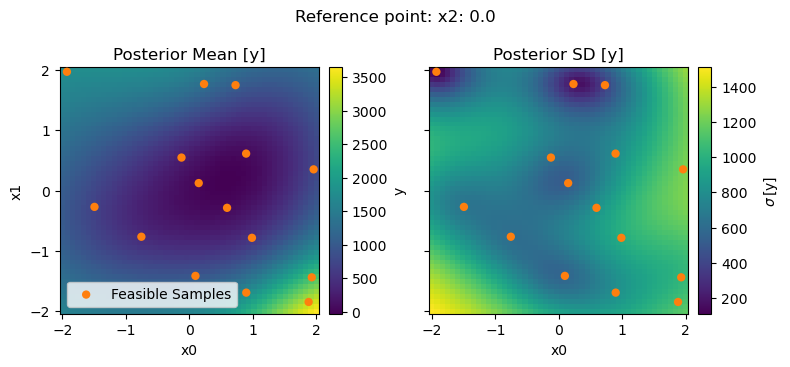

In [6]:
from xopt.generators.bayesian.visualize import visualize_model

fig, ax = visualize_model(
    model,
    vocs,
    data,
    variable_names=["x0","x1"],
    reference_point={"x2":0.0}
)